Cancer Integration with NCGA < https://portal.gdc.cancer.gov/

There is an API, however since we are only dealing with 31 GAIN domains / 32 receptors, I grabbed all data in JSON. https://docs.gdc.cancer.gov/

In [ ]:
%matplotlib inline
import json, glob, re, math

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)
import matplotlib.pyplot as plt

import sse_func
from gain_classes import *
jsons = glob.glob("../repo_data/gain_json/*.json")
csvs = glob.glob("/home/hildilab/projects/agpcr_nom/snp_mane/*csv")

The loaded JSON will contain a list of dictionaries, where every dictionary corresponds to a single mutation of the respective receptor. With the pre-defined window, we have a list of mutations, where the keys correspond to properties of respective mutations.

In [ ]:
'''print(j.split("/")[-1].split(".")[0].upper(), "CANCER GENOME ATLAS MUTATIONS\n","_"*70)
positions = []
for mutation in mutation_data['mutations']:
    for key in mutation.keys():
        print(key.ljust(30), mutation[key])
    print("_"*70)
    resid = int(mutation["x"]) # X is the residue ID
    positions.append(resid)
    
def totext(f, stuff):
    with  open(f, 'a') as txt:
        txt.write(stuff)
'''

We need to construct a new dictionary where the indexing itself locates to. This can be a new attribute of the class
Let's construct the human collection first.

In [ ]:
# Initialize the human GAIN collection
def filter_by_list(sequences, selection): # selection list
    new_list = []
    for seq_tup in sequences:
        for it in selection:
            if it in seq_tup[0]:
                new_list.append(seq_tup)
    return new_list

quality_file = "/home/hildilab/projects/agpcr_nom/app_gain_gain.mafft.jal"
alignment_file = "/home/hildilab/projects/agpcr_nom/app_gain_gain.mafft.fa"
stride_folder = "/home/hildilab/projects/agpcr_nom/all_gps_stride"
stride_files = glob.glob("/home/hildilab/projects/agpcr_nom/sigmas/sigma_2/*")
quality = sse_func.read_quality(quality_file)
gps_minus_one = 6781 # -1 of the ACTUAL COLUMN (6782) in JALVIEW since there is is ONE-INDEXED
aln_cutoff = 6826 # 

alignment_dict = sse_func.read_alignment(alignment_file, aln_cutoff)
valid_seqs = sse_func.read_multi_seq("/home/hildilab/projects/agpcr_nom/app_gain_gain.fa")
human_seqs = ["Q9HBW9","O60241","Q6QNK2","Q9UHX3","Q5T601","Q96PE1","O60242","Q86SQ4",
                "O94910","Q8IWK6","Q8IZP9","Q8WXG9","Q86Y34","O95490","Q14246","Q9BY15",
                "Q8IZF2","Q86SQ3","Q8IZF6","Q96K78","Q8IZF3","Q8IZF7","Q8IZF5","Q7Z7M1",
                "Q8IZF4","Q9HCU4","Q9NYQ6","Q9NYQ7","Q9HAR2","O14514","P48960",
                "Q9Y653"]
sigma_2_strides = glob.glob("/home/hildilab/projects/agpcr_nom/sigma_2*/*.stride")
list_32 = filter_by_list(valid_seqs, human_seqs)

human_collection = GainCollection( alignment_file = alignment_file,
                                        aln_cutoff = aln_cutoff,
                                        quality = quality,
                                        gps_index = gps_minus_one,
                                        stride_files =  sigma_2_strides, #stride_files,
                                        sequence_files=None,
                                        sequences=list_32,
                                        alignment_dict = alignment_dict,
                                        coil_weight=0.00, # won't work with altered boundary detection
                                        is_truncated = True,
                                        stride_outlier_mode = True
                                         )

For each GAIN domain within this collection, map the mutations by residue on the corresponding element. Then, merge all that to construct a global mutation map.

In [ ]:
# VALID DATA FROM THE MSA AND THE ANALYSIS PIPELINE
sdb = 3425
# ADJUSTED ANCHORS!
anchors = [ 662, 1194, 1912, 2490, 2848, 3011, 3073, 3260, 3455, 3607, 3998, 4279, 4850, 5339,
 5413, 5813, 6337, 6659, 6696, 6765, 6808] # removed S7 @  5341
anchor_occupation = [ 4594.,  6539., 11392., 13658.,  8862., 5092.,  3228., 14189.,  9413., 12760.,
  9420., 11201., 12283.,  3676.,   13992., 12575., 13999., 14051., 14353., 9760., 14215.] # removed S7 @ 4562.,

anchor_dict = sse_func.make_anchor_dict(anchors, 3425)

gain_adresses = {}
named_dirs = []
for gain_idx, gain in enumerate(human_collection.collection):
    _,_, named_dir, _ = sse_func.create_indexing(gain, anchors, anchor_occupation, anchor_dict)
    named_dirs.append(named_dir)
    gain.idx_dir = named_dir
    gain.rev_idx_dir = {v: k for k, v in named_dir.items()}
    gain_adresses[gain_idx] = gain.name

rev_named_dirs = []
for named_dir in named_dirs:
    rev_dir = {v: k for k, v in named_dir.items()}
    rev_named_dirs.append(rev_dir)

In [ ]:
### FUNCTION BLOCK FOR VARIANT FILE PARSING AND LOOP CONSTRUCTION.

def retrieve_json_vars(name,jsons):
    # A function retrieving variants from a JSON File as exported by TCGA/NCGA, returning them as a dictionary
    # The list of {jsons} is filtered to find {name}
    # Returns a loaded dict from the json.
    try: 
        identifier = name.split("AGR")[1][:2] # When its a normal aGPCR
    except: 
        identifier = "C"+name.split("CELR")[1][0]

    json_identifier = identifier.lower()
    json_file = [j for j in jsons if json_identifier in j.lower()]
    #print(f"DEBUG : retrieve_mutation_json: {json_file = }" )
    if len(json_file) > 1 : print("WARNING: Multiple matching JSON Files detected:", json_file)
    with open(json_file[0]) as j_open:
        j_data = j_open.read()
    mutation_data = json.loads(j_data) # Will contain a list of dicts
    return mutation_data

def retrieve_csv_vars(name, csv_files, filter_str=None, with_resid=True):
    # A function retrieving variants from a CSV File as exported by gnomAD, returning them as a dictionary
    # The list of {csv_files} is filtered to find {name}, filter_str is used to find specific mutations, i.e. missense
    # With_resid also adds the residue and the standard AA at this position to the mutation entries.
    # Returns a list of dict, where each dict corresponds to one mutation
    try: 
        identifier = name.split("AGR")[1][:2] # When its a normal aGPCR
    except: 
        identifier = "C"+name.split("CELR")[1][0]

    csv_identifier = identifier.lower()
    csv_file = [c for c in csv_files if csv_identifier in c.lower()]
    print(f"DEBUG : parse_snp_csv: {csv_file = }" )
    
    # the target CSV files have 53 items per row. RETURNS columns: dict where key points to axis 1 index of np.array; val_arr: value array 
    with open(csv_file[0]) as cc:
        data = cc.readlines()

    # Pre-filter the data if specified.
    if filter_str is not None:
        newdata = [l for l in data[1:] if filter_str in l]
        data = [data[0]]
        for l in newdata: 
            data.append(l)

    oneletter = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C','Gln':'Q','Glu':'E','Gly':'G','His':'H',
                 'Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Pyl':'O','Ser':'S','Thr':'T',
                'Trp':'W','Tyr':'Y','Val':'V'}

    variant_list = []
    variant_keys = data[0].strip().split(",")

    for i,row in enumerate(data[1:]):
        row = re.sub(r'\".*\"', 'REMOVED', row)   # Removes combined irrelevant entries that contain a "," within string denotation. This confuses the split routine.
        var_dict = {variant_keys[i]:val for i,val in enumerate(row.strip().split(","))}
        #print("DEBUG", var_dict)
        if with_resid:
            var_string = var_dict['Protein Consequence']
            #print(f"DEBUG: {var_string = }")
            if len(var_string) < 2:
                var_dict['resid'] = None
                var_dict['resname'] = None
            else:
                var_dict['resname'] = oneletter[re.search(r'[A-z]{3}', var_string).group(0)]
                var_dict['resid'] = int(re.search(r'[\d]+', var_string).group(0))
        variant_list.append(var_dict)

    return variant_list

def extract_variants(gain, files, resid_key):
    # Wrapper function for getting variants / mutations in the correct format.
    # Draws the list of vars/muts from the respective list of jsons/csvs abd gets the individual positions either at entry 
    # resid_key : 'x' (json from NCGA) / 'resid' (csv from gnomAD)
    gain_name = gain.name

    if files[0][-3:].lower() == 'csv':
        print("List of CSV files detected.")
        vars = retrieve_csv_vars(gain_name, csvs, filter_str='missense_variant',with_resid=True)
    else:
        print("This should be a list of JSON Files.")
        v_dict = retrieve_json_vars(gain_name, files,)
        vars = [mut for mut in v_dict['mutations']]
        # returns a dictionary with a list of dicts, each dict corresponding to a var.
    variant_dict = {}
    positions = []
    for var in vars:
        # The "x" key is the identifying position!
        resid = int(var[resid_key]) 
        #
        # Here, one can define criteria for skipping said var. For now, use all.
        #
        # Add the receptor name to the var dictionary
        var["receptor"] = gain_name

        if resid in variant_dict.keys():
            variant_dict[resid].append(var)
        else:
            variant_dict[resid] = [var]
        positions.append(resid)
    return positions, variant_dict

def get_loop_stats(indexing_dir, sequence):
    # Returns a named dict with loop lengths, i.e. {"H1-H2":13, "H8-S1":12}
    inverted_dir = {sse[0] : (sse[1],ki) for ki, sse in indexing_dir.items() if "GPS" not in ki} # The begin of each sse is here {0:(13, "H2")}
    loop_loc = {}
    loop_dir = {}
    ordered_starts = sorted(inverted_dir.keys())
    for i, sse_start in enumerate(ordered_starts):
        if i == 0: 
            continue # Skip the first and go from the second SSE onwards, looking in N-terminal direction.
        c_label = inverted_dir[sse_start][1]
        n_end, n_label = inverted_dir[ordered_starts[i-1]]
        loop_loc[f"{n_label}-{c_label}"] = (n_end, sse_start-1)
        loop_dir[f"{n_label}-{c_label}"] = sequence[n_end+1:sse_start] # The one-letter-coded seqeuence. Will be a list of lists
    return loop_loc, loop_dir

def compose_vars(aGainCollection, files, resid_key, aa_key, fasta_offsets):
    # Take the Gain Collection and retrieve variant/mutation info from the files list via extract_variants()
    # Collect these for each GAIN in the aGainCollection.collection and compose them together to enable addressing each individual labeled position.
    # Returns the generalized (aligned) variants/mutations and their respective counts
    mismatch_flag = False
    generalized_vars = {}
    valid = 0
    invalid = 0

    for gain_ndx, gain in enumerate(aGainCollection.collection):
        gain_valid = 0
        gain_invalid = 0
        fasta_offset = fasta_offsets[gain_ndx]
        # Retrieve vars/mutations for respective receptor
        positions, gain_pos_dict = extract_variants(gain, files, resid_key)
        # Find all vars/mutations whose RESID (fasta) matches the corrected GAIN domain INTERVAL(for fasta resids)
        within = [pos for pos in positions if pos in range(fasta_offset, fasta_offset + 1 + gain.end - gain.start)]
        #print("DEBUG: vars/mutations within GAIN space\n", sorted(within))
        # Evaluate the vars/mutations. If the residue in question (corrected index) is named (i.e. "H6.50"), get its resepective label.
        for p_resid in gain_pos_dict.keys():
            # Since fasta_offset maps to the first gain residue (i.e. 2027 with gain.start being 459), an offset needs to be set by the difference
            corrected_resid = p_resid - fasta_offset + gain.start -1
            #print(f"DEBUG {corrected_resid = }, {p_resid = }
            #   TRUE GAIN INTERVAL {fasta_offset+gain.start} - {fasta_offset+gain.end}\nCORRECTED GAIN INTERVAL {gain.start}-{gain.end}")
            # map it to its corresponding label. If there is none, continue
            try:
                p_label = gain.rev_idx_dir[corrected_resid]
                gain_valid +=1
            except KeyError:
                gain_invalid += 1
                continue
            # SANITY CHECK:
            if gain_pos_dict[p_resid][0][aa_key][0] != gain.sequence[corrected_resid-gain.start]:
                print(f"{gain_pos_dict[p_resid][0][aa_key][0] = }", {gain.sequence[corrected_resid-gain.start]})
                print(f"MISMATCH! {p_resid} -> {corrected_resid}")
                print(f"{gain_pos_dict[p_resid][0][aa_key][0]} : {gain.sequence[corrected_resid-gain.start]} in GAIN",
                    f"{gain.sequence[corrected_resid-gain.start-2:corrected_resid-gain.start+3]}")
                mismatch_flag = True
            #else:
                #print(f"MATCH {p_resid} -> {corrected_resid} | {gain_mutation_dict[p_resid][0][aa_key][0]} : {gain.sequence[corrected_resid-gain.start]}")
            
            # with the Label, map into generalized dictionary
            if p_label not in generalized_vars.keys():
                generalized_vars[p_label] = gain_pos_dict[p_resid]
            else:
                [generalized_vars[p_label].append(pos) for pos in gain_pos_dict[p_resid]]
        valid += gain_valid
        invalid += gain_invalid
        print("VALID MAPPED POSITIONS: ", gain_valid, "\nINVALID POSITIONS     : ", gain_invalid, "\nTOTAL POSITIONS       : ", len(gain_pos_dict.keys()))
    if mismatch_flag: 
        print("[WARNING]: MISMATCHES HAVE BEEN FOUND. PLEASE CHECK THE OUTPUT.")
    else: 
        print("[NOTE]: NO MISMATCHES HAVE BEEN FOUND.")
    print(f"TOTAL VARS WITHIN GAIN:", valid, "\nTOTAL VARS OUTSIDE GAIN:", invalid, "\nTOTAL VARS:", valid+invalid)
    
    generalized_counts = {k:len(v) for k,v in generalized_vars.items()}

    return generalized_vars, generalized_counts

def loop2fasta(outfile, itemlist):
    # Write the collected loop sequences to a FASTA file for later alignment.
    with open(outfile, 'w') as out:
        for subdict in itemlist:
            out.write(f">{subdict['name']}\n{subdict['sequence']}\n")
    print("Done with", outfile)

def compose_loop_vars(aGainCollection, files, resid_key, aa_key, fasta_offsets):
    # Take the Gain Collection and retrieve variant/mutation info from the files list via extract_variants()
    # Collect these for each GAIN in the aGainCollection.collection and compose them together to enable addressing each individual labeled position.
    # Returns the generalized (aligned) variants/mutations and their respective counts
    mismatch_flag = False
    generalized_vars = {}
    valid = 0
    invalid = 0

    loop_valid = 0
    loop_invalid = 0
    for idx, gain in enumerate(aGainCollection.collection):
    # Retrieve vars/mutations for respective receptor
        positions, gain_pos_dict = extract_variants(gain, files, resid_key)
        fasta_offset = fasta_offsets[idx]
        # Find all vars/mutations whose RESID (fasta) matches the corrected GAIN domain INTERVAL(for fasta resids)
        within = [pos for pos in positions if pos in range(fasta_offset, fasta_offset + 1 + gain.end - gain.start)]
        #print("DEBUG: vars/mutations within GAIN space\n", sorted(within))
        idx_dir, _, _, _ = sse_func.create_indexing(gain, anchors, anchor_occupation, anchor_dict, outdir=None, offset=fasta_offsets[idx], silent=True, split_mode='double')
        # i.e. 'H2-H3': (13, 20), 'H3-H4': (36, 42), 'H4-H5': (61, 75), 'H5-H6': (87, 89), ...., 'S11-S12': (316, 319), 'S12-S13': (327, 329)}
        i_loc, _ = get_loop_stats(idx_dir, gain.sequence)
        # Modify this to a position --> loop dict
        loop_locations = {}
        for loop, interval in i_loc.items():
            for i in range(interval[0], interval[1]+1):
                loop_locations[i+gain.start] = loop
        # Evaluate the vars/mutations. If the residue in question (corrected index) is named (i.e. "H6.50"), get its resepective label.
        print("DEBUG")
        #[print(i,k) for i,k in loop_locations.items()]

        for p_resid in gain_pos_dict.keys():
            # Since fasta_offset maps to the first gain residue (i.e. 2027 with gain.start being 459), an offset needs to be set by the difference
            corrected_resid = p_resid - fasta_offset + gain.start -1
            # Check in which loop this is located and collect it in a dictionary.
            try:
                loop_label = loop_locations[corrected_resid]
                loop_valid +=1
            except KeyError:
                loop_invalid += 1
                continue
            # SANITY CHECK:
            if gain_pos_dict[p_resid][0][aa_key][0] != gain.sequence[corrected_resid-gain.start]:
                print(f"{gain_pos_dict[p_resid][0][aa_key][0] = }", {gain.sequence[corrected_resid-gain.start]})
                print(f"MISMATCH! {p_resid} -> {corrected_resid}")
                print(f"{gain_pos_dict[p_resid][0][aa_key][0]} : {gain.sequence[corrected_resid-gain.start]} in GAIN",
                    f"{gain.sequence[corrected_resid-gain.start-2:corrected_resid-gain.start+3]}")
                mismatch_flag = True
            # with the Label, map into generalized dictionary
            if loop_label not in generalized_vars.keys():
                generalized_vars[loop_label] = gain_pos_dict[p_resid]
            else:
                [generalized_vars[loop_label].append(pos) for pos in gain_pos_dict[p_resid]]
        valid += loop_valid
        invalid += loop_invalid
        print("VALID LOOP POSITIONS: ", loop_valid, "\nINVALID POSITIONS     : ", loop_invalid, "\nTOTAL POSITIONS       : ", len(gain_pos_dict.keys()))
    if mismatch_flag: 
        print("[WARNING]: MISMATCHES HAVE BEEN FOUND. PLEASE CHECK THE OUTPUT.")
    else: 
        print("[NOTE]: NO MISMATCHES HAVE BEEN FOUND.")
    print(f"TOTAL VARS WITHIN GAIN:", valid, "\nTOTAL VARS OUTSIDE GAIN:", invalid, "\nTOTAL VARS:", valid+invalid)
    
    generalized_counts = {k:len(v) for k,v in generalized_vars.items()}

    return generalized_vars, generalized_counts

Construct a Dictionary with info to all mutations at respective RESID. Also just make a list with the resids to summarize all entry occurences.

In [22]:
generalized_counts = {}     # For every nomenclature label, the number of MUTATION entries is denoted
generalized_mutations = {}  #   ^ The info behind the entries is here.
gen_var_counts = {}         # For every nomenclature label, the number of VARIANT entries is denoted
gen_vars = {}               #   ^ The info behind the entries is here.
invalid = 0
valid = 0

mismatch_flag = False
fasta_offsets = [2027, 2106, 2175, 479, 632, 588, 568, 528, 517, 579, 723, 2449, 
                 5619, 546, 0, 300, 22, 140, 112, 356, 154, 96, 365, 415, 265, 
                 170, 235, 120, 418, 269, 324]
total_within = 0
for gain_ndx, gain in enumerate(human_collection.collection):
    gain_valid = 0
    gain_invalid = 0
    fasta_offset = fasta_offsets[gain_ndx]
    # Retrieve mutations for respective receptor
    positions, gain_mutation_dict = extract_variants(gain, jsons, 'x')
    # Retrieve variants for respective receptor
    var_positions, var_dict = extract_variants(gain, csvs, 'resid')
    # Find all mutations whose RESID (fasta) matches the corrected INTERVAL(for fasta resids)
    within = [pos for pos in positions if pos in range(fasta_offset, fasta_offset + 1 + gain.end - gain.start)]
    #print("DEBUG: Mutations within GAIN space\n", sorted(within))
    # Go through the gain_mutation_dict and add into the two dicts
    total_within += len(within)
    """print("EXTENT OF MUTATIONS IN TARGET RESIDUE INTERVAL:\nINTERVAL\t\t:",fasta_offset, fasta_offset + 1 + gain.end - gain.start,
        "\n FIRST OCC\t\t:",within[0], 
        "\n LAST OCC\t\t:",within[-1],
        "\n TOTAL MUT\t\t:",len(positions),
        "\n WITHIN INTERVAL\t:", len(within),
        "\n DEBUG: RESID WITHIN", within
        )"""
    # Evaluate the mutations. If the residue in question (corrected index) is named (i.e. "H6.50"), get its resepective label.
    for mutated_resid in gain_mutation_dict.keys():
        # Since fasta_offset maps to the first gain residue (i.e. 2027 with gain.start being 459), an offset needs to be set by the difference
        corrected_resid = mutated_resid - fasta_offset + gain.start -1
        # map it to its corresponding label. If there is none, continue
        try:
            mutated_label = gain.rev_idx_dir[corrected_resid]
            #print(mutated_label)
            gain_valid +=1
        except KeyError:
            gain_invalid += 1
            continue
        # SANITY CHECK:
        if gain_mutation_dict[mutated_resid][0]['aa_change'][0] != gain.sequence[corrected_resid-gain.start]:
            print(f"MISMATCH! {mutated_resid} -> {corrected_resid}",
                 f"{gain_mutation_dict[mutated_resid][0]['aa_change'][0]} : {gain.sequence[corrected_resid-gain.start]} in GAIN",
                 f"{gain.sequence[corrected_resid-gain.start-2:corrected_resid-gain.start+3]}")
            mismatch_flag = True
        #else:
            #print(f"MATCH {mutated_resid} -> {corrected_resid} | {gain_mutation_dict[mutated_resid][0]['aa_change'][0]} : {gain.sequence[corrected_resid-gain.start]}")
        
        # with the Label, map into generalized dictionary
        if mutated_label not in generalized_mutations.keys():
            generalized_mutations[mutated_label] = gain_mutation_dict[mutated_resid]
        else:
            [generalized_mutations[mutated_label].append(mutation) for mutation in gain_mutation_dict[mutated_resid]]
    valid += gain_valid
    invalid += gain_invalid
    print("VALID MAPPED POSITIONS: ", gain_valid, "\nINVALID POSITIONS     : ", gain_invalid, "\nTOTAL POSITIONS       : ", len(gain_mutation_dict.keys()))
if mismatch_flag: 
    print("[WARNING]: MISMATCHES HAVE BEEN FOUND. PLEASE CHECK THE OUTPUT.")
else: 
    print("[NOTE]: NO MISMATCHES HAVE BEEN FOUND.")
print(f"TOTAL MUTATIONS WITHIN GAIN:", valid, "\nTOTAL MUTATIONS OUTSIDE GAIN:", invalid, "\nTOTAL MUTATIONS:", valid+invalid)

This should be a list of JSON Files.
List of CSV files detected.
DEBUG : parse_snp_csv: csv_file = ['/home/hildilab/projects/agpcr_nom/snp_mane/c2.csv']
VALID MAPPED POSITIONS:  24 
INVALID POSITIONS     :  346 
TOTAL POSITIONS       :  370
This should be a list of JSON Files.
List of CSV files detected.
DEBUG : parse_snp_csv: csv_file = ['/home/hildilab/projects/agpcr_nom/snp_mane/c1.csv']
VALID MAPPED POSITIONS:  23 
INVALID POSITIONS     :  358 
TOTAL POSITIONS       :  381
This should be a list of JSON Files.
List of CSV files detected.
DEBUG : parse_snp_csv: csv_file = ['/home/hildilab/projects/agpcr_nom/snp_mane/c3.csv']
VALID MAPPED POSITIONS:  15 
INVALID POSITIONS     :  387 
TOTAL POSITIONS       :  402
This should be a list of JSON Files.
List of CSV files detected.
DEBUG : parse_snp_csv: csv_file = ['/home/hildilab/projects/agpcr_nom/snp_mane/f3.csv']
VALID MAPPED POSITIONS:  12 
INVALID POSITIONS     :  81 
TOTAL POSITIONS       :  93
This should be a list of JSON Files.
L

In L3, there is a mismatch between canonical (UniProtKB) and the GDC form (equiv. Isoform 4) - see MSA mapping
D2 (2/2)   | GDC ENST00000334810 = D2-201 (971 aa) - Uniprot Q7Z7M1 (963 aa) - Files OK - remap the four mutations in question : 496, 556, 460, 386, 507 -->  514, 529, 478, 404, X --> MSA mapping manual curation of these four mutations
F4 (23/26) | GDC ENST00000283303 (695 aa) - Uniprot Q8IZF3 (695 aa) - Re-Download resolved all errors
E2 (6/20)  | GDC ENST00000315576 (823 aa) - Uniprot Q9UHX3 (823 aa) - Re-Download resolved all errors


In [23]:
# Generate the dictionaries for the SNPs and the Cancer mutations.
fasta_offsets = [2027, 2106, 2175, 479, 632, 588, 568, 528, 517, 579, 723, 2449, 
                 5619, 546, 0, 300, 22, 140, 112, 356, 154, 96, 365, 415, 265, 
                 170, 235, 120, 418, 269, 324]
mutations, mut_counts = compose_vars(human_collection, jsons, 'x', 'aa_change', fasta_offsets)
snps, snp_counts = compose_vars(human_collection, csvs, 'resid', 'resname', fasta_offsets)

#print(valid, invalid, valid+invalid, total_within)
# For each GAIN domain in the collection, count the occurence of a specific label
occupancy_dict = {}
for gain in human_collection.collection:
    #rev_dir = {v: k for k, v in gain.named_dir.items()}
    for key in gain.idx_dir.keys():
        if key not in occupancy_dict.keys():
            occupancy_dict[key] = 1
        else:
            occupancy_dict[key] += 1

This should be a list of JSON Files.
VALID MAPPED POSITIONS:  24 
INVALID POSITIONS     :  346 
TOTAL POSITIONS       :  370
This should be a list of JSON Files.
VALID MAPPED POSITIONS:  23 
INVALID POSITIONS     :  358 
TOTAL POSITIONS       :  381
This should be a list of JSON Files.
VALID MAPPED POSITIONS:  15 
INVALID POSITIONS     :  387 
TOTAL POSITIONS       :  402
This should be a list of JSON Files.
VALID MAPPED POSITIONS:  12 
INVALID POSITIONS     :  81 
TOTAL POSITIONS       :  93
This should be a list of JSON Files.
VALID MAPPED POSITIONS:  28 
INVALID POSITIONS     :  212 
TOTAL POSITIONS       :  240
This should be a list of JSON Files.
VALID MAPPED POSITIONS:  18 
INVALID POSITIONS     :  183 
TOTAL POSITIONS       :  201
This should be a list of JSON Files.
VALID MAPPED POSITIONS:  52 
INVALID POSITIONS     :  465 
TOTAL POSITIONS       :  517
This should be a list of JSON Files.
VALID MAPPED POSITIONS:  24 
INVALID POSITIONS     :  158 
TOTAL POSITIONS       :  182
Th

Plotting the Cancer-enrichement scores of Positions. For each SSE, count the mutations/SNPs at each position and generate a score according to 
Wright et al. 2019 https://doi.org/10.1038/s41467-019-08630-2 - cancer-enriched positions will have a positive score.

In [ ]:
def compose_y(x_range, sse, count_dict):
    y_vals = np.zeros(shape=len(x_range))
    for i, val in enumerate(x_range):
        k = f"{sse}{val}"
        try:
            y_vals[i] = count_dict[k]
        except:
            pass
    return y_vals

def score(m,v):
    mmax = max(m)
    vmax = max(v)
    return [math.log10( ((m[i]/mmax)+1) / ((v[i]/vmax)+1) ) for i in range(len(m))]            

order = [f"H{str(num)}." for num in range(1,9)]
[order.append(f"S{str(num)}.") for num in range(1,14)]
order.append("GPS")

for sse in order:
# mutations, mut_counts
# snps, snp_counts
    varkeys = [k for k in mut_counts.keys() if sse in k]+[k for k in snp_counts.keys() if sse in k]
    #print(subkeys)
    if sse == "GPS":
        x_range = (1,2,3)
        mut_y = [mut_counts["GPS-1"], mut_counts["GPS+1"], 0]
        var_y = [mut_counts["GPS-1"], mut_counts["GPS+1"], 0]
    if sse != 'GPS':
        x_positions = [int(x.split('.')[-1]) for x in varkeys]
        x_range = range(min(x_positions), max(x_positions)+1)
        mut_y = compose_y(x_range, sse, mut_counts)
        var_y = compose_y(x_range, sse, snp_counts)

    fig, ax = plt.subplots(1,3, figsize=(8,2))
    fig.tight_layout()
    fig.set_facecolor('w')
    score_y = score(mut_y,var_y)
    y_max = max(var_y)
    xlab = [f"{sse}{p}" for p in x_range][::3]
    for a in ax:    #ax = plt.subplot(1,3,2)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.spines['left'].set_visible(False)
        a.xaxis.set_minor_locator(MultipleLocator(1)) #AutoMinorLocator())
        a.xaxis.set_major_locator(FixedLocator([a for a in range(2,100,3)]))#MultipleLocator(3))
        a.tick_params(which='both', width=2)
        a.tick_params(which='major', length=8)
        a.tick_params(which='minor', length=6)

    ax[0].set_ylim(-0.2, y_max)
    ax[0].set_title(f'Cancer Variation ({sse[:-1]})')
    ax[0].bar(x_range, mut_y, width=1.1, color='silver')  

    ax[1].set_ylim(-0.2, y_max)
    ax[1].set_title(f'Natural Variation ({sse[:-1]})')
    ax[1].bar(x_range, var_y, width=1.1, color='silver')

    ax[2].set_title(f'Combined Variation ({sse[:-1]})')
    ax[2].hlines(0, min(x_range), max(x_range), color='dimgray', linewidth=0.7)
    for i in range(len(x_range)):
        if score_y[i] < 0:
            cx = 'xkcd:blurple'
        else:
            cx = 'xkcd:tomato red'
            if score_y[i] > 0.05:
                label = f'{sse}{x_range[i]}'
                print(f'{label},{round(score_y[i],2)}')
        ax[2].bar(x_range[i], score_y[i], color=cx)

    for a in ax:
        a.set_xticklabels([f'{sse}{str(int(v))}' for v in a.get_xticks()], rotation=90)
        
    #fig.savefig(f"../fig/{sse}.variants.svg", bbox_inches='tight')
    #plt.show()
    #plt.show(fig)
    #plt.close()
    plt.close(fig)


In [13]:
#generalized_mutations.keys()

names = []
nums = []
occus = []
# Construct a sequence of secondary structural elements.
order = [f"H{str(num)}." for num in range(1,9)]
[order.append(f"S{str(num)}.") for num in range(1,13)]
order.append("GPS-2")
order.append("GPS-1")
order.append("GPS+1")
order.append("S13.")

for k, v in snps.items():
    print(k, len(v))

#print(order)
# Enumerate SSE Sequence and find the corresponding keys, smash together into $names, $nums, $occus
for sse in order:
    #print(sse)
    keys = sorted([ki for ki in generalized_mutations.keys() if sse in ki])
    for ki in keys:
        #print(ki,  len(generalized_mutations[ki]))#, "\tOCC",occupancy_dict[ki])
        pass
        #mut_names.append(ki)                                # The position
        #mut_nums.append(len(generalized_mutations[ki]))     # Number of mutations at this position
        #mut_occus.append(occupancy_dict[ki])                # The mutations (data) in question


H2.43 4
H2.45 8
H2.48 6
H2.49 8
H3.41 9
H3.42 11
H3.45 15
H3.46 11
H3.47 6
H3.49 18
H3.51 14
H3.52 15
H3.53 8
H3.54 9
H4.40 19
H4.43 15
H4.46 11
H4.50 11
H4.51 7
H4.52 19
H4.56 10
H5.48 11
H5.51 13
H5.52 11
H5.55 21
H6.51 7
H6.52 9
H6.58 5
H8.47 12
H8.48 23
H8.49 30
H8.50 13
H8.53 16
H8.54 12
H8.56 25
H8.58 17
H8.63 15
H8.66 4
S1.52 11
S2.50 17
S2.51 11
S2.52 12
S2.54 11
S2.56 19
S2.58 4
S4.49 13
S5.48 8
S5.50 12
S5.52 7
S5.53 17
S5.54 15
S5.56 2
S7.50 14
S7.51 11
S7.52 10
S7.55 18
S8.45 3
S8.49 5
S8.50 13
S8.51 9
S8.52 15
S8.53 16
S8.55 18
S9.54 14
S10.51 18
S11.53 19
S11.54 19
S11.55 11
S12.48 20
S12.51 29
S12.52 7
GPS-1 12
GPS+1 17
S13.48 9
S13.51 25
S13.52 12
S13.49 15
S13.46 14
S12.49 28
S11.51 26
S10.49 25
S9.53 5
S9.51 17
S7.54 13
S7.53 18
S5.51 18
S5.49 15
S4.51 14
S4.50 13
S2.55 13
S1.50 13
H8.68 1
H8.67 2
H8.65 1
H8.62 8
H8.61 12
H8.55 18
H8.52 23
H8.46 17
H8.45 5
H6.59 6
H5.56 10
H5.50 11
H5.49 20
H5.47 11
H5.46 9
H4.58 8
H4.57 4
H4.53 17
H4.49 5
H4.45 17
H4.44 18
H4.41 10
H

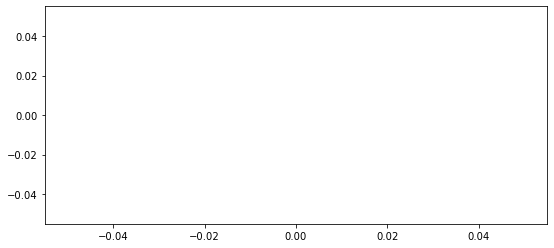

In [14]:
import numpy as np
#print(names)
fig = plt.figure(figsize=[9,4])
fig.set_facecolor("w")
ymax = 15
col_dict = { "H" : "dodgerblue",
             "S" : "darkorange",
             "G" : "forestgreen"}
label_x = [0]
label_txt = ["GPS"]
stored = "H"
stored_x = 0
for lab_idx, label in enumerate(names):
    #print(label.split(".")[0])
    if label.split(".")[0] != stored:
        if label not in ["GPS-1","GPS+1"]:
            box_col = col_dict[stored[0]]
            col = col_dict[label[0]]
            
            plt.vlines(lab_idx, 0,ymax, color=col, alpha=0.4)
            plt.fill_between([stored_x, lab_idx], 0, ymax, color=box_col, alpha=0.2)
            
            stored_x = lab_idx
            stored = label.split(".")[0]
            
            label_x.append(lab_idx)
            label_txt.append(label.split(".")[0])

        plt.xticks(ticks = label_x, labels = label_txt, rotation=45)
        #plt.yticks(ticks = [0,1,2], labels = ["0", "100%", "200%"])
        #plt.ylabel("Mutation Number over Position Occurence")
        plt.xlabel("Element name")
#plt.fill_between([stored_x, lab_idx], 0, ymax, color="darkorange", alpha=0.2)
#for x in range(len(nums)):
#    alfa = 0.2+(0.8*occus[x]/31)
#    plt.scatter(x, nums[x]/occus[x], color='red', alpha=alfa, s=11)
#plt.plot(range(len(nums)),nums, linewidth=1.5, color='black')
#plt.bar(range(len(nums)),nums, color='black')
plt.scatter(range(len(nums)),np.divide(nums, occus), color='red', s=6)
#plt.savefig("corr.human_indexed_.png", bbox_inches='tight', dpi=300)

In [ ]:
#b-factor : line[60:66]
d1_gain = human_collection.collection[26]
print(d1_gain.name, d1_gain.start, d1_gain.end)
ref_pdb = "d1_gain.pdb"
with open(ref_pdb) as inpdb:
    pdb_data = inpdb.readlines()
#names, nums, occus
print(d1_gain.idx_dir)
new_data = []
for line in pdb_data:
    if not line.startswith("ATOM"):
        new_data.append(line)
        continue
    resid = int(line[22:26])
    try:
        position_label = d1_gain.rev_idx_dir[resid-1] # i.e. "H2.54", account for zero vs. one-indexed!
        try: 
            b = float(len(generalized_mutations[position_label]))
            #print(position_label, len(generalized_mutations[position_label]))
        except KeyError:
            b = 0.0
    except KeyError: 
        b = 0.0
    new_data.append(line[:61]+"%6.2f"%(b)+line[68:])

with open("d1_gain_mut.pdb","w") as outpdb:
    for line in new_data:
        outpdb.write(line)
print("Done.")


In [ ]:
#b-factor : line[60:66]
for i, gain in enumerate(human_collection.collection):
    if "AGRL1" in gain.name: 
        print(i)
        break
l1_gain = human_collection.collection[i]
print(l1_gain.name, l1_gain.start, l1_gain.end)
ref_pdb = "../repo_data/l1_gain.pdb"
with open(ref_pdb) as inpdb:
    pdb_data = inpdb.readlines()
#names, nums, occus
print(l1_gain.idx_dir)
new_data = []
for line in pdb_data:
    if not line.startswith("ATOM"):
        new_data.append(line)
        continue
    resid = int(line[22:26])
    try:
        position_label = l1_gain.rev_idx_dir[resid-1] # i.e. "H2.54" account for 0-indexed residues in the dictionary!
        try: 
            b = float(len(generalized_mutations[position_label]))
            #print(position_label, len(generalized_mutations[position_label]))
        except KeyError:
            b = 0.0
    except KeyError: 
        b = 0.0
    new_data.append(line[:61]+"%6.2f"%(b)+line[68:])

with open("l1_gain_mut.pdb","w") as outpdb:
    for line in new_data:
        outpdb.write(line)
print("Done.")


In [30]:

#print(generalized_mutations[label])
def position_vars(gen_vars, label, aa_key=None, text_out=None, return_aa=False):
    # Prints or writes to File the mutations at a specific label position.
    def tee(file_obj=None, text_string=""):
        # Selector function similar to UNIX "tee" -> where it prints and - if existing - writes to File.
        if file_obj is not None:
            file_obj.write(text_string)
        print(text_string, end='')

    if text_out is not None: # Initialize TEXT output file if specified. Otherwise construct None
        text = open(text_out, 'w')
    else: text = None

    #tee(text, f"CANCER GENOME ATLAS MUTATIONS AT POSITION {label.upper()} \nTOTAL: {len(gen_vars[label])} MUTATIONS\n\n")

    rstring=''
    for var in gen_vars[label]:
        for key in var.keys():
            if return_aa and key == 'aa_change':
                    rlet = var[key][0]
                    rstring = rstring+rlet
            #tee(text, f"{key.ljust(30)} {var[key]}\n")
        if aa_key is not None:
            resid = int(var[aa_key]) # X is the residue ID
        #tee(text, "\n"+"_"*30+"\n")
    print(label, ",", rstring)

enriched_positions = ['H1.50','H1.54','H1.57','H1.61','H2.56','H2.57','H2.60','H2.61','H3.36','H3.43',
'H3.44','H3.51','H3.53','H3.56','H4.38','H4.41','H4.51','H5.37','H5.38','H5.42','H5.44',
'H5.48','H5.50','H5.59','H6.42','H6.54','H6.56','H7.40','H7.51','H8.46','H8.58','H8.60',
'S1.48','S2.47','S2.51','S2.53','S2.58','S3.53','S3.55','S4.56','S5.48','S5.52','S5.55',
'S6.50','S7.45','S7.52','S7.57','S9.53','S10.50','S11.54','S11.55','S12.47','S12.50','S12.52','S13.48','S13.50']

for label in enriched_positions:
    position_vars(generalized_mutations, label, return_aa=True)#text_out=f"../mut/{label}.out", return_aa=True)

H1.50 , L
H1.54 , II
H1.57 , A
H1.61 , A
H2.56 , KKK
H2.57 , I
H2.60 , D
H2.61 , Q
H3.36 , RR
H3.43 , AAAPPA
H3.44 , SSEAS
H3.51 , RRRAVCRR
H3.53 , ALLSQ
H3.56 , RRRR
H4.38 , ASS
H4.41 , GGGEGMGGA
H4.51 , ARREDMDAKKEQD
H5.37 , K
H5.38 , RRRR
H5.42 , AS
H5.44 , GEEKNN
H5.48 , AAESE
H5.50 , VMMSI
H5.59 , EL
H6.42 , E
H6.54 , WWWWWWW
H6.56 , EDVVF
H7.40 , R
H7.51 , A
H8.46 , GAAASAATL
H8.58 , AASSTGMD
H8.60 , VIVIAAA
S1.48 , AAVMAA
S2.47 , S
S2.51 , VAAQAAS
S2.53 , EAEEE
S2.58 , PPSD
S3.53 , IIAA
S3.55 , ST
S4.56 , R
S5.48 , VILVS
S5.52 , GTCHG
S5.55 , ILSYSF
S6.50 , SSV
S7.45 , VV
S7.52 , SVASASS
S7.57 , SA
S9.53 , WWWWWWWWWW
S10.50 , WWWWWWW
S11.54 , SDEQVYYQR
S11.55 , RESSEGG
S12.47 , HRYGEEQ
S12.50 , CCCC
S12.52 , CCCC
S13.48 , AAGAA
S13.50 , LYLLI


In [16]:
def query_criteria(*pairs, sift=None, poly=None, mutation_dict):
    # Defines a function where key - value pairs will be used to specifically filter criteria to be applied for subselection of mutations.
    #       i.e. ("consequence", "missense"), ("sift_impact","deleterious")
    # Scores "sift" and "polyphen" define minimum and maximum values with an operator to determine lower than or higher than $val cutoffs
    #       i.e. ("sift_score", ">", 0.22) as tuples
    print("DEBUG:", pairs)
    def eval_entry(pairs, entry):
        if pairs is None:
            return True

        for tup in pairs:
            if entry[tup[0]] != tup[1]:
                return False
        return True

    # Set a custom_func flag indicating if there are custom dependent lambda functions for scores specified
    custom_func = True
    if sift is None and poly is None:
        custom_func = False
    if sift is None:
        sift = lambda n: True
    if poly is None:
        poly = lambda n: True

        
    print("DEBUG", custom_func)

    valid_ct = 0
    out_dict = {}
    # We want to filter the generalized dictionary by key
    for ki in mutation_dict.keys():
        mutation_list = mutation_dict[ki]
        filtered_mutation_list = []
        for mutation in mutation_list:
            # Check the scores first. If there are no scores, but custom functions specified, thats ok. Otherwise, do not consider this entry
            try: 
                s = float(mutation["sift_score"])
                p = float(mutation["polyphen_score"])
            except:
                #print("Scores not in Entry...", end ='')
                if custom_func == True:
                    continue
                print("But no score functions specified")
            if custom_func and not sift(float(mutation["sift_score"])):
                continue
            if custom_func and not poly(float(mutation["polyphen_score"])):
                continue
            # Here, check the *pairs argument if that matches the specifications.
            if not eval_entry(pairs, mutation):
                continue
            
            valid_ct += 1
            filtered_mutation_list.append(mutation)
        out_dict[ki] = filtered_mutation_list
    print(f"Found {valid_ct} entries matching criteria.")
    return out_dict
            
# Example Lambda Functions for score evaluation
poly = lambda n : n > 0.446 # > 0.446 for possibly damaging, > 0.908 for Probably Damaging
sift = lambda n : n < 0.05 # For deleterious impacts

In [17]:
#missense_dict = query_criteria(("consequence", "missense"), poly=lambda n : n > 0.446, mutation_dict=generalized_mutations)
missense_dict2 = query_criteria(mutation_dict=generalized_mutations)

DEBUG: ()
DEBUG False
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score functions specified
But no score function

In [ ]:
for gain in human_collection.collection:
    if "AGRL3" in gain.name:
        print("DEBUG:", gain.name, gain.idx_dir, "".join(gain.sequence))

In [21]:
csvs = glob.glob("/home/hildilab/projects/agpcr_nom/snp_mane/*csv")

parse_dict, data = retrieve_csv_vars(csvs[0], 
                                    return_keys=['Protein Consequence', 'Transcript', 'Transcript Consequence', 'VEP Annotation'], 
                                    filter_str = 'missense_variant'
                                    )
print(data)
# Filter for VEP annotation to only get the missense mutation
oneletter = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C','Gln':'Q','Glu':'E','Gly':'G','His':'H','Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Pyl':'O','Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V'}
idx = parse_dict['Protein Consequence']
for mutation in data[idx,:]:
    res = oneletter[re.match(r'[A-z]{3}')[0]] # A, D, ...
    resnum = re.match(r'[\d]+', mutation) # 1364


TypeError: retrieve_csv_vars() got an unexpected keyword argument 'return_keys'

In [ ]:
# Lets map the vars/mutations to the loops as wäll

loop_lengths = {}
loop_seqs = {}
loop_seq = {}

loop_info = {}
#[loop_info[loop] = {} for loop in loop_seqs.keys()] # into each of these keys, any entry is composed of "name":$name, "sequence":$seq

for idx, gain in enumerate(human_collection.collection):
    curr_name = gain.name
    idx_dir, cent, named_dir, _ = sse_func.create_indexing(gain, anchors, anchor_occupation, anchor_dict, outdir=None, offset=fasta_offsets[idx], silent=True, split_mode='double')
    #print(f'{named_dir = }')
    i_loc, i_dir = get_loop_stats(idx_dir, gain.sequence)
    for k, seq in i_dir.items():
        if k not in loop_info.keys():
            loop_info[k] = []
        loop_info[k].append({'name':f'{gain.name}_{i_loc[k][0]+gain.start}-{i_loc[k][1]+gain.start}', 'sequence':''.join(seq)})

#for loop in loop_info.keys():
#    loop2fasta(f"../loops_human/{loop}.fa", loop_info[loop])

# mafft
mafft_aln = glob.glob('../loops_human/aln/*fa')


In [18]:
# Construct a labeled dict with each connector containing the corresponding mutations for this - independent of the receptor
# ie "H8-S1": [{mut1}, {mut2}]
# we rather not use the Alignment to sort mutations, since the loops themselves have too much variability as shown in the ALN. Subfamily-level.

loop_muts, loop_counts = compose_loop_vars(human_collection, jsons, resid_key='x', aa_key='aa_change', fasta_offsets=fasta_offsets)

for loop in loop_counts.keys():
    print(loop, loop_counts[loop])
    #for k, seq in i_dir.items():
    #    if k not in loop_info.keys():
    #        loop_info[k] = []
    #    loop_info[k].append({'name':f'{gain.name}_{i_loc[k][0]+gain.start}-{i_loc[k][1]+gain.start}', 'sequence':''.join(seq)})


This should be a list of JSON Files.
[[], [], [], [], [], [], [0, 18]]
[(array([ 0, 13]), ['H2.38', 'H2.39', 'H2.40', 'H2.41', 'H2.42', 'H2.43', 'H2.44', 'H2.45', 'H2.46', 'H2.47', 'H2.48', 'H2.49', 'H2.50', 'H2.51'], (array([ 0, 13]), 12, 'H2'))]
[(array([ 90, 101]), ['H6.48', 'H6.49', 'H6.50', 'H6.51', 'H6.52', 'H6.53', 'H6.54', 'H6.55', 'H6.56', 'H6.57', 'H6.58', 'H6.59'], (array([ 90, 101]), 92, 'H6'))]
[[], [], [], [], [], [], [], [], [], [], [], [], [], []]
DEBUG
VALID LOOP POSITIONS:  21 
INVALID POSITIONS     :  349 
TOTAL POSITIONS       :  370
This should be a list of JSON Files.
[[], [], [], [1], [], [], [0, 18]]
[(array([ 0, 13]), ['H2.38', 'H2.39', 'H2.40', 'H2.41', 'H2.42', 'H2.43', 'H2.44', 'H2.45', 'H2.46', 'H2.47', 'H2.48', 'H2.49', 'H2.50', 'H2.51'], (array([ 0, 13]), 12, 'H2'))]
[(array([ 90, 101]), ['H6.48', 'H6.49', 'H6.50', 'H6.51', 'H6.52', 'H6.53', 'H6.54', 'H6.55', 'H6.56', 'H6.57', 'H6.58', 'H6.59'], (array([ 90, 101]), 92, 'H6'))]
[[], [], [], [], [], [], [],

In [20]:
#position_vars(loop_muts,'S9-S10', aa_key='x')
[position_vars(generalized_mutations, x) for x in generalized_mutations.keys() if 'S9' in x]

CANCER GENOME ATLAS MUTATIONS AT POSITION S9.52 
TOTAL: 6 MUTATIONS

id                             739c9590-5175-56c3-b6a7-7b776c41f9b9
y                              1
genomic_dna_change             chr3:g.48646107C>G
x                              2482
consequence                    missense
impact                         MODERATE
sift_impact                    tolerated
polyphen_impact                benign
sift_score                     0.56
polyphen_score                 0.261
aa_change                      Q2482H
receptor                       Q9NYQ7_O75092-CELR3_HUMAN-CadherinEGFLAGseven-passG-typereceptor3-Homo_sapiens

______________________________
id                             d2b87d5b-5cda-5580-8b6b-9eeae38b77f5
y                              1
genomic_dna_change             chr6:g.69076021G>C
x                              821
consequence                    missense
impact                         MODERATE
sift_impact                    tolerated
polyphen_impact          

[None, None, None, None, None, None, None, None, None, None, None]